# Generate and load cached data 

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from parse_results import process_results_xml
import yaml
import os

In [2]:
settings_file = Path('settings_defaults.yaml')

if settings_file.exists():
    with settings_file.open() as f:
        params = yaml.load(f, Loader=yaml.FullLoader)
else:
    params = {}
    
working_dir_path = params.get('temp_dir', 'temp_dir')
all_data_file = params.get('data_file', 'all_data.csv')
working_dir = Path(working_dir_path)
data_cache_path = working_dir.joinpath(all_data_file)

In [3]:
# Ensure the working directory exists
if not working_dir.exists():
    working_dir.mkdir(parents=True)

# Temp files
metrics_path = working_dir.joinpath('metrics.csv')
scores_path = working_dir.joinpath('scores.csv')
details_path = working_dir.joinpath('test_details.csv')
    
# Load any existing chached data or start empty if they don't exist
if working_dir.joinpath('metrics.csv').exists():
    try:
        metrics_data = pd.read_csv(str(metrics_path), parse_dates=['start', 'end'])
        scores = pd.read_csv(str(scores_path))
        test_details = pd.read_csv(str(details_path), index_col=0)
        sert_data = pd.read_csv(str(data_cache_path), parse_dates=['start', 'end'])
    except Exception as e:
        print('Reloading failed, exception: ', e)

# What scenarios have been tested?
Using a 3 bin strategy for temperature testing and high and low for pressure.

In [4]:
#test_details
total_score = scores[scores['workload'] == 'All'].dropna(axis=1)
total_score = total_score.merge(test_details, left_on='test-name', right_index=True, how='left').dropna()
total_score['scenario'] = list(' - '.join(x) for x in zip(total_score['model'], total_score['cpu']))
total_score['temperature'] = total_score.apply(lambda row: sert_data[sert_data['test-name'] == row['test-name']]['temp-avg'].mean(), axis=1)
total_score['temperature-range'] = total_score.apply(lambda row: sert_data[sert_data['test-name'] == row['test-name']]['temp-max'].max() - sert_data[sert_data['test-name'] == row['test-name']]['temp-min'].min(), axis=1)
total_score = total_score.merge(sert_data[sert_data['workload'] == 'Idle'][['watts-avg','test-name']], left_on='test-name', right_on='test-name').rename(columns={'watts-avg':'idle-power'})
total_score['max-power'] = total_score.apply(lambda row: sert_data[(sert_data['test-name'] == row['test-name']) & (sert_data['loadlevel']=='100%')]['watts-avg'].mean(), axis=1)
total_score['pressure'] = total_score.apply(lambda row: sert_data[sert_data['test-name'] == row['test-name']]['pressure'].mean(), axis=1)
#total_score.pressure.isnull().values.any()
total_score.pressure.isnull().sum()
total_score =total_score[total_score['bios']!='unknown']
tested = total_score.groupby(['scenario', 'bios', pd.cut(total_score.pressure, [total_score.pressure.min(), 15, total_score.pressure.max()]), pd.cut(total_score.temperature,[20, 23.5,27.5, 30])]).size().unstack().unstack()
tested.style.applymap(lambda x: 'background-color:pink' if x < 3 else None)

# Overview of results

In [38]:

total_score[total_score['temperature'] < 23.3].groupby(['scenario', 'bios'])[['temperature','efficiency-score', 'idle-power', 'max-power']].mean().round(2)

temperature  \
scenario                                           bios                       
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 0... Efficiency         21.60   
                                                   Performance        21.35   
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 v... Efficiency         21.50   
                                                   Performance        22.18   
PowerEdge R630 - Intel(R) Xeon(R) CPU E5-2690 v... Efficiency         21.88   
                                                   Performance        20.93   
PowerEdge R640 - Intel(R) Xeon(R) Gold 6148 CPU... Efficiency         20.67   
                                                   Performance        20.99   
PowerEdge R640 - Intel(R) Xeon(R) Silver 4116 C... Efficiency         21.79   
                                                   Performance        20.85   

                                                                efficiency-score  \
scenario                                           bios                            
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 0... Efficiency              12.02   
                                                   Performance              8.94   
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 v... Efficiency              16.89   
                                                   Performance             12.75   
PowerEdge R630 - Intel(R) Xeon(R) CPU E5-2690 v... Efficiency              20.16   
                                                   Performance             15.28   
PowerEdge R640 - Intel(R) Xeon(R) Gold 6148 CPU... Efficiency              21.07   
                                                   Performance             18.37   
PowerEdge R640 - Intel(R) Xeon(R) Silver 4116 C... Efficiency              22.37   
                                                   Performance             20.92   

                                                                idle-power  \
scenario                                           bios                      
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 0... Efficiency        87.98   
                                                   Performance      224.83   
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 v... Efficiency        69.84   
                                                   Performance      180.15   
PowerEdge R630 - Intel(R) Xeon(R) CPU E5-2690 v... Efficiency        88.34   
                                                   Performance      202.17   
PowerEdge R640 - Intel(R) Xeon(R) Gold 6148 CPU... Efficiency        86.36   
                                                   Performance      216.69   
PowerEdge R640 - Intel(R) Xeon(R) Silver 4116 C... Efficiency        83.40   
                                                   Performance      153.58   

                                                                max-power  
scenario                                           bios                    
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 0... Efficiency      340.76  
                                                   Performance     375.17  
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 v... Efficiency      301.66  
                                                   Performance     333.60  
PowerEdge R630 - Intel(R) Xeon(R) CPU E5-2690 v... Efficiency      300.94  
                                                   Performance     336.65  
PowerEdge R640 - Intel(R) Xeon(R) Gold 6148 CPU... Efficiency      353.80  
                                                   Performance     399.91  
PowerEdge R640 - Intel(R) Xeon(R) Silver 4116 C... Efficiency      204.27  
                                                   Performance     226.15

In [43]:

total_score[(total_score['temperature'] > 23.3) & (total_score['temperature'] < 26.6)].groupby(['scenario', 'bios'])[['temperature','efficiency-score', 'idle-power', 'max-power']].mean().round(2)

temperature  \
scenario                                           bios                       
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 0... Efficiency         23.99   
                                                   Performance        25.13   
PowerEdge R630 - Intel(R) Xeon(R) CPU E5-2690 v... Efficiency         23.51   
PowerEdge R640 - Intel(R) Xeon(R) Gold 6148 CPU... Efficiency         24.01   
                                                   Performance        25.19   
PowerEdge R640 - Intel(R) Xeon(R) Silver 4116 C... Efficiency         25.23   
                                                   Performance        25.25   

                                                                efficiency-score  \
scenario                                           bios                            
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 0... Efficiency              11.89   
                                                   Performance              8.73   
PowerEdge R630 - Intel(R) Xeon(R) CPU E5-2690 v... Efficiency              20.08   
PowerEdge R640 - Intel(R) Xeon(R) Gold 6148 CPU... Efficiency              20.92   
                                                   Performance             18.03   
PowerEdge R640 - Intel(R) Xeon(R) Silver 4116 C... Efficiency              22.10   
                                                   Performance             20.58   

                                                                idle-power  \
scenario                                           bios                      
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 0... Efficiency        88.48   
                                                   Performance      232.81   
PowerEdge R630 - Intel(R) Xeon(R) CPU E5-2690 v... Efficiency        88.83   
PowerEdge R640 - Intel(R) Xeon(R) Gold 6148 CPU... Efficiency        86.81   
                                                   Performance      221.42   
PowerEdge R640 - Intel(R) Xeon(R) Silver 4116 C... Efficiency        84.50   
                                                   Performance      148.68   

                                                                max-power  
scenario                                           bios                    
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 0... Efficiency      343.85  
                                                   Performance     383.91  
PowerEdge R630 - Intel(R) Xeon(R) CPU E5-2690 v... Efficiency      302.73  
PowerEdge R640 - Intel(R) Xeon(R) Gold 6148 CPU... Efficiency      356.79  
                                                   Performance     408.31  
PowerEdge R640 - Intel(R) Xeon(R) Silver 4116 C... Efficiency      205.26  
                                                   Performance     218.40

In [44]:
total_score[(total_score['temperature'] > 26.6)].groupby(['scenario', 'bios'])[['temperature','efficiency-score', 'idle-power', 'max-power']].mean().round(2)

temperature  \
scenario                                           bios                       
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 0... Performance        28.50   
PowerEdge R640 - Intel(R) Xeon(R) Gold 6148 CPU... Efficiency         27.17   
                                                   Performance        26.84   
PowerEdge R640 - Intel(R) Xeon(R) Silver 4116 C... Efficiency         27.79   
                                                   Performance        27.79   

                                                                efficiency-score  \
scenario                                           bios                            
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 0... Performance              8.47   
PowerEdge R640 - Intel(R) Xeon(R) Gold 6148 CPU... Efficiency              20.71   
                                                   Performance             17.95   
PowerEdge R640 - Intel(R) Xeon(R) Silver 4116 C... Efficiency              22.07   
                                                   Performance             20.53   

                                                                idle-power  \
scenario                                           bios                      
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 0... Performance      237.74   
PowerEdge R640 - Intel(R) Xeon(R) Gold 6148 CPU... Efficiency        87.47   
                                                   Performance      223.84   
PowerEdge R640 - Intel(R) Xeon(R) Silver 4116 C... Efficiency        82.11   
                                                   Performance      149.09   

                                                                max-power  
scenario                                           bios                    
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 0... Performance     400.24  
PowerEdge R640 - Intel(R) Xeon(R) Gold 6148 CPU... Efficiency      360.01  
                                                   Performance     414.46  
PowerEdge R640 - Intel(R) Xeon(R) Silver 4116 C... Efficiency      205.74  
                                                   Performance     218.82

# Energy Efficiency vs SERT Load Level
 

Text(0.5, 1.1, 'CPU Worklet Performance')

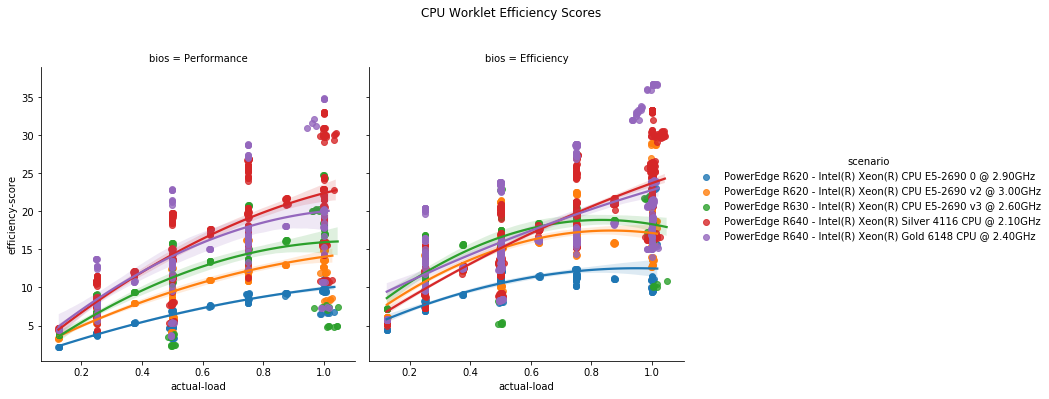

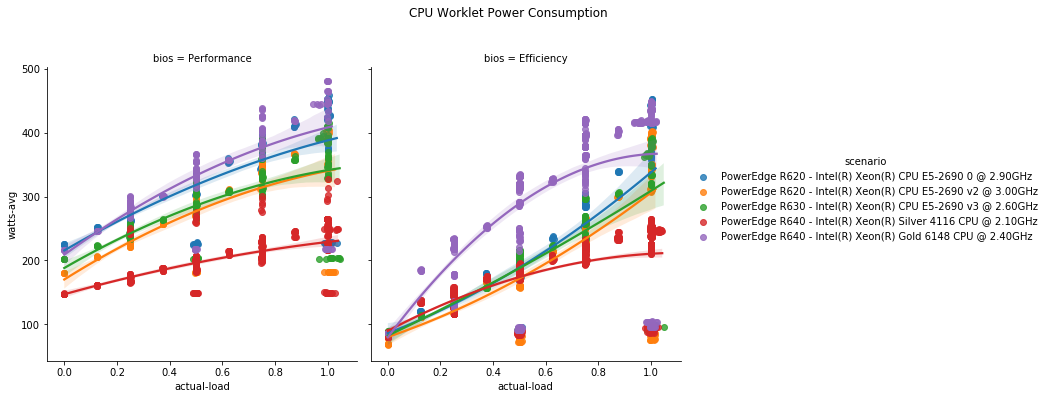

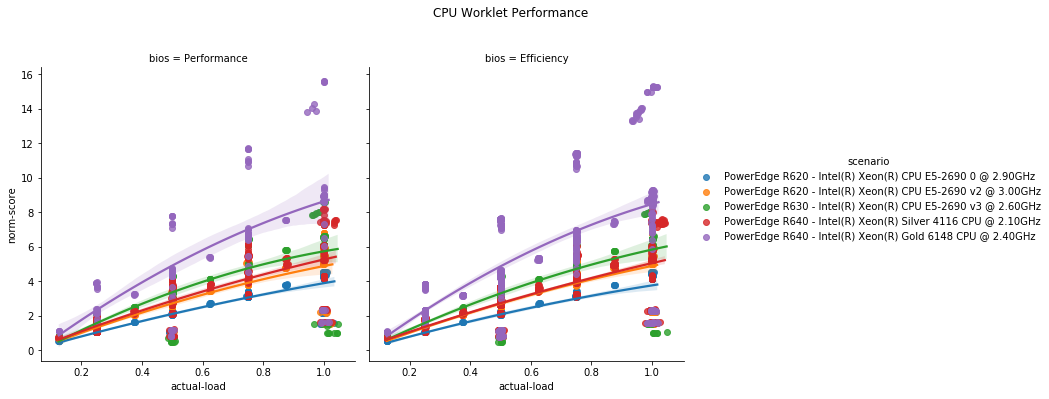

In [5]:
cpu = sert_data[(sert_data['workload'] == 'CPU')| (sert_data['workload'] == 'Idle')]
cpu = sert_data[(sert_data['bios'] == 'Efficiency')| (sert_data['bios'] == 'Performance')]
sns.lmplot(x='actual-load', y='efficiency-score', hue='scenario', col='bios', 
           data=cpu[cpu['temp-avg'] < 23.5], order=2, truncate=True, scatter=True).fig.suptitle('CPU Worklet Efficiency Scores', y=1.1)
sns.lmplot(x='actual-load', y='watts-avg', hue='scenario', col='bios', 
           data=cpu[cpu['temp-avg'] < 23.5], order=2, truncate=True, scatter=True).fig.suptitle('CPU Worklet Power Consumption', y=1.1)
sns.lmplot(x='actual-load', y='norm-score', hue='scenario', col='bios', 
           data=cpu[cpu['temp-avg'] < 23.5], order=2, truncate=True, scatter=True).fig.suptitle('CPU Worklet Performance', y=1.1)

A cleaner plot without the individual data plotted for each sert run. 

Text(0.5, 1, 'CPU Worklet Efficiency Scores ( Test Temperature < 23.3C)')

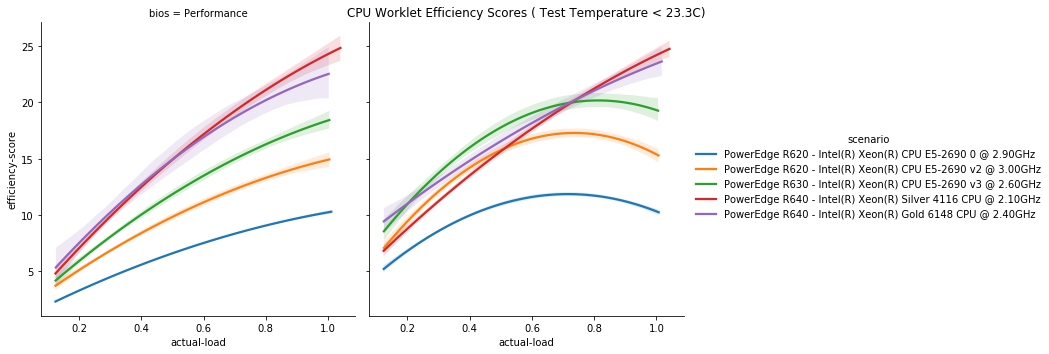

In [32]:
sns.lmplot(x='actual-load', col='bios', y='efficiency-score', hue='scenario', data=cpu[cpu['temp-avg'] < 23.3], order=2, truncate=True, scatter=False)
ax = plt.gca()
ax.set_title('CPU Worklet Efficiency Scores ( Test Temperature < 23.3C)')

# Energy Efficiency vs Ambient Temperature


Hypothesis: Server power consumption increases as temperature increases reducing server efficiency. As PUE values approach 1 an increasing portion of the Data centre's power is used in the server therfore there is likely to be a trade-off on operating temperature depending on cooling infrastructure and number of servers in the datacenter. 


Text(0.5, 1.1, 'using total_score')

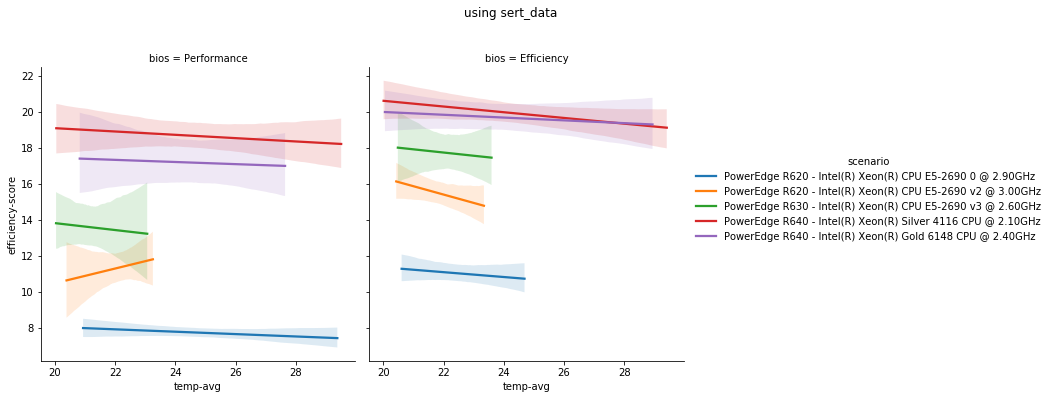

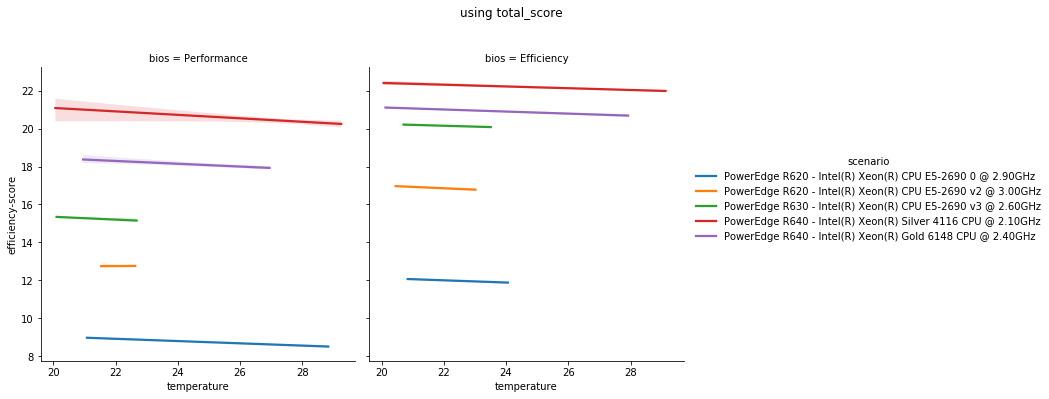

In [8]:
sert_data = sert_data[(sert_data['bios'] == 'Efficiency')| (sert_data['bios'] == 'Performance')]

sns.lmplot(x='temp-avg', y='efficiency-score', hue='scenario',col='bios', data=sert_data, order=1, scatter=False).fig.suptitle('using sert_data', y=1.1)

sns.lmplot(x='temperature', y='efficiency-score', hue='scenario',col='bios', data=total_score, order=1, scatter=False).fig.suptitle('using total_score', y=1.1)

#sns.lmplot(x='temp-avg', y='watts-avg', hue='scenario',col='bios', data=sert_data, order=1, scatter=False)

#sns.lmplot(x='temp-avg', y='norm-score', hue='scenario',col='bios', data=sert_data, order=1, scatter=False)

# Energy Efficiency vs CPU Utilisation


c:\users\n.rteil\appdata\local\programs\python\python37\lib\site-packages\ipykernel-5.1.4-py3.7.egg\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


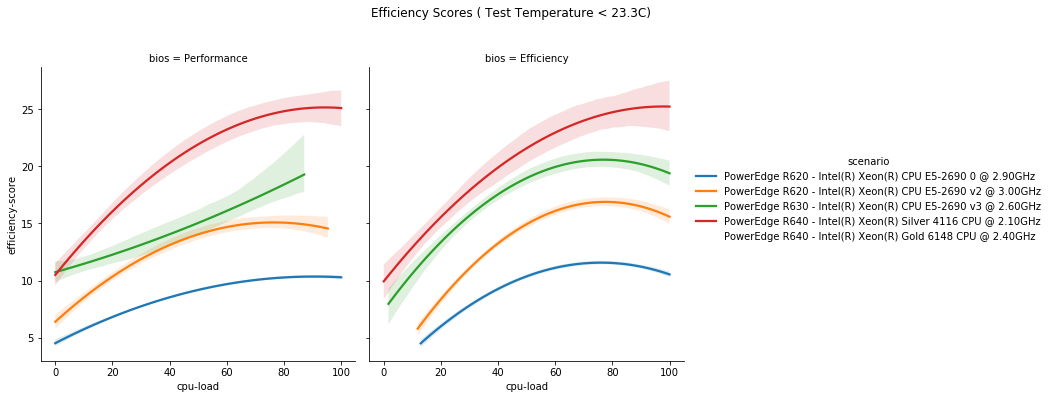

In [33]:

cpu_metrics = pd.read_csv(f'{working_dir}//cpu_metrics.csv', index_col='Time', parse_dates=['Time'])
cpu_metrics['avg-temp'] = cpu_metrics.filter(regex='Temp').mean(axis=1, skipna=True)
cpu_metrics['avg-load'] = cpu_metrics.filter(regex='load').mean(axis=1, skipna=True)
cpu_metrics['avg-freq'] = cpu_metrics.filter(regex='speed').mean(axis=1, skipna=True)


#pd.to_datetime(cpu_metrics['Time']
sert_data['cpu-power'] = sert_data.apply(lambda row: cpu_metrics['total cpu power'][row['start'].tz_localize(None):row['end'].tz_localize(None)].mean(), axis=1)
sert_data['chassis-power'] = sert_data['watts-avg'] - sert_data['cpu-power']

sert_data['cpu-temp'] = sert_data.apply(lambda row: cpu_metrics['avg-temp'][row['start'].tz_localize(None):row['end'].tz_localize(None)].mean(), axis=1)
sert_data['cpu-load'] = sert_data.apply(lambda row: cpu_metrics['avg-load'][row['start'].tz_localize(None):row['end'].tz_localize(None)].mean(), axis=1)
sert_data['cpu-freq'] = sert_data.apply(lambda row: cpu_metrics['avg-freq'][row['start'].tz_localize(None):row['end'].tz_localize(None)].mean(), axis=1)

cpu_worklets = sert_data[(sert_data['workload'] == 'Idle') | (sert_data['workload'] == 'CPU')]
cpu_worklets['scenario'] = list(' - '.join(x) for x in zip(cpu_worklets['model'], cpu_worklets['cpu']))
sns.lmplot(x='cpu-load', y='efficiency-score', hue='scenario', col='bios', data=cpu_worklets[cpu_worklets['temp-avg'] < 23.3], order=2, truncate=True, scatter=False).fig.suptitle('Efficiency Scores ( Test Temperature < 23.3C)', y=1.1)
#plt.ylim([0, None])
plt.show()

# Impact of BIOS Mode on Energy Efficiency (for each server)

Text(0.5, 1.1, 'Efficiency Scores for BIOS modes per SERT load level')

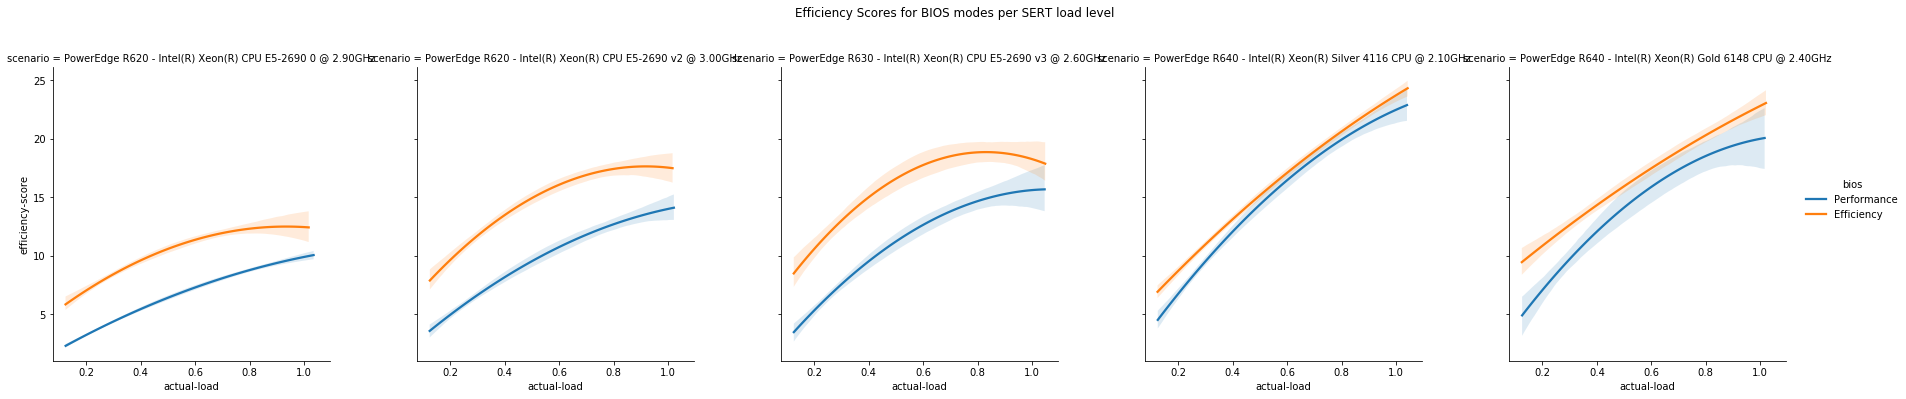

In [18]:
sns.lmplot(x='actual-load', y='efficiency-score', hue='bios', col='scenario', 
           data=cpu[cpu['temp-avg'] < 22.5], order=2, truncate=True, scatter=False).fig.suptitle('Efficiency Scores for BIOS modes per SERT load level', y=1.1)

(0, 28.186624397240642)

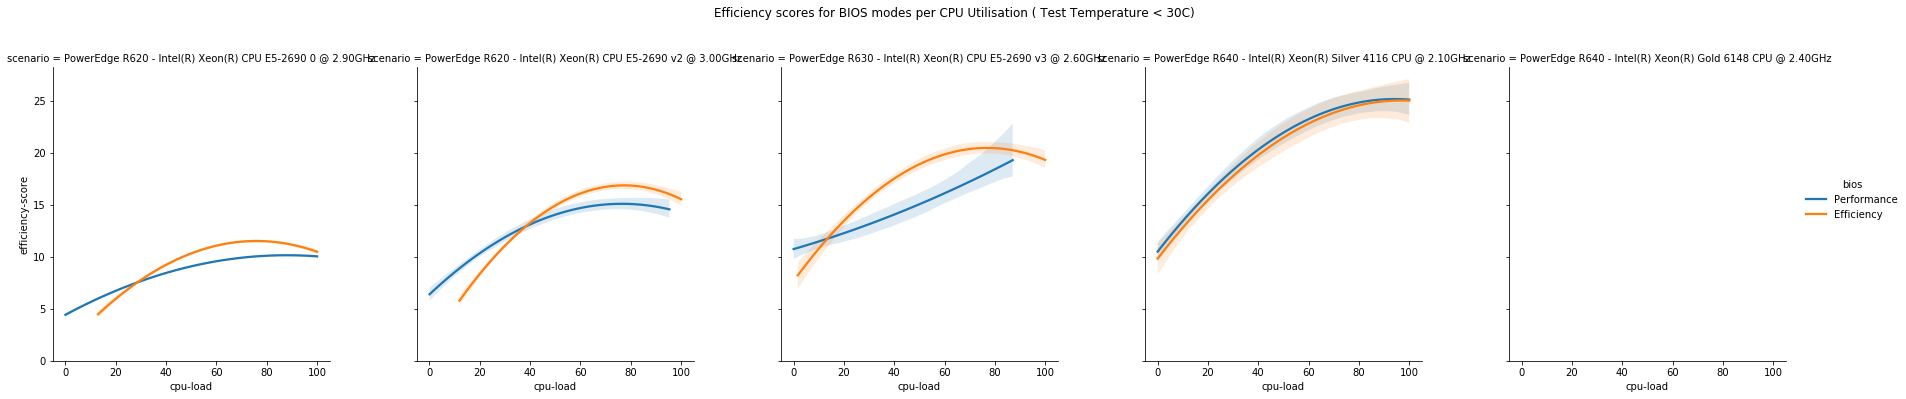

In [20]:

sns.lmplot(x='cpu-load', y='efficiency-score', hue='bios', col='scenario', data=cpu_worklets[(cpu_worklets['temp-avg'] < 30) & (cpu_worklets['bios']!='unknown')], order=2, truncate=True, scatter=False).fig.suptitle('Efficiency scores for BIOS modes per CPU Utilisation ( Test Temperature < 30C)', y=1.1)
plt.ylim([0, None])

# CPU vs Chassis power consumption

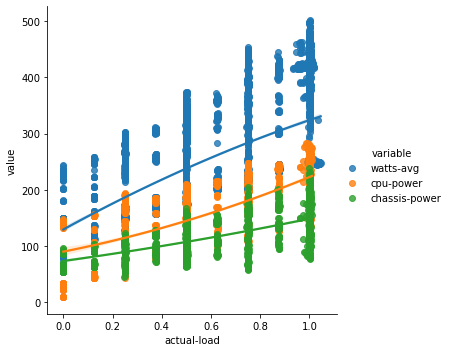

In [21]:
plotdf = cpu_worklets.melt('actual-load', ['watts-avg', 'cpu-power', 'chassis-power'])

sns.lmplot(x='actual-load', y='value', hue='variable', data=plotdf, order=2)

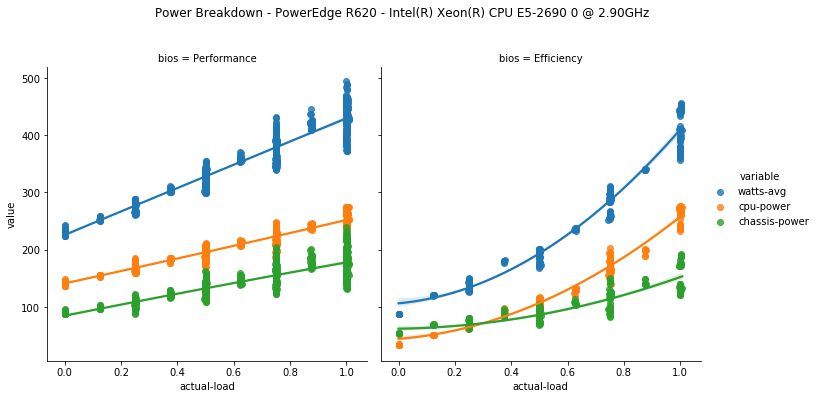

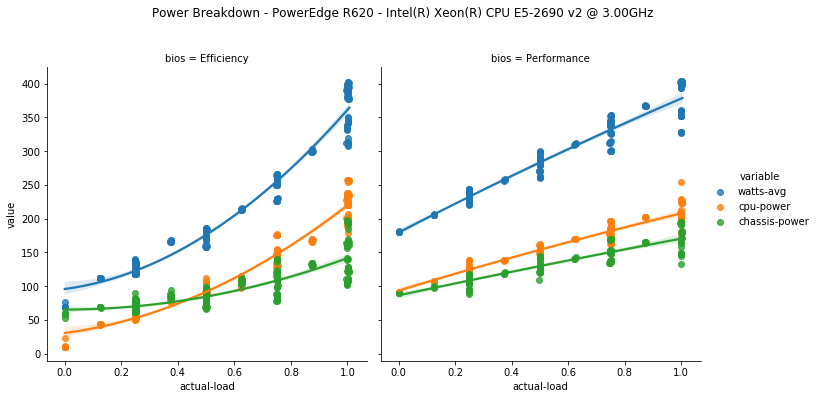

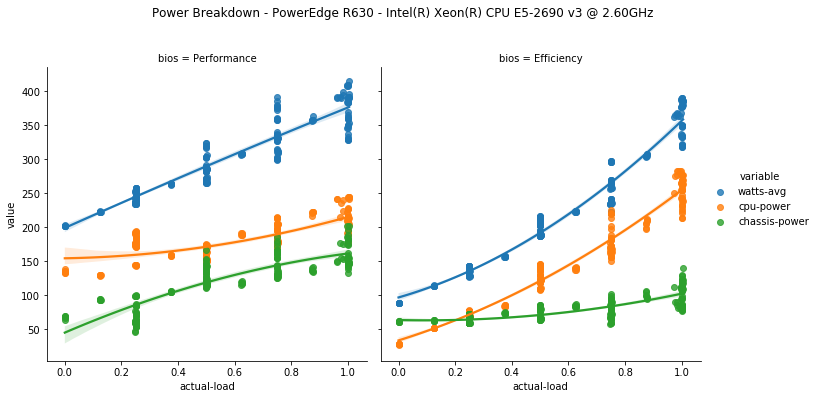

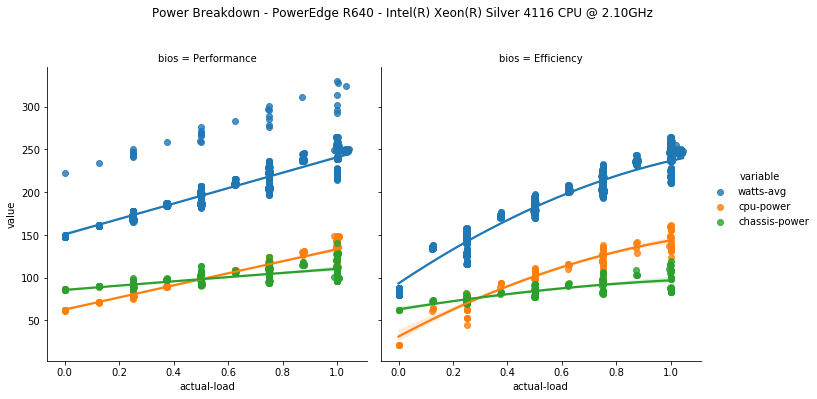

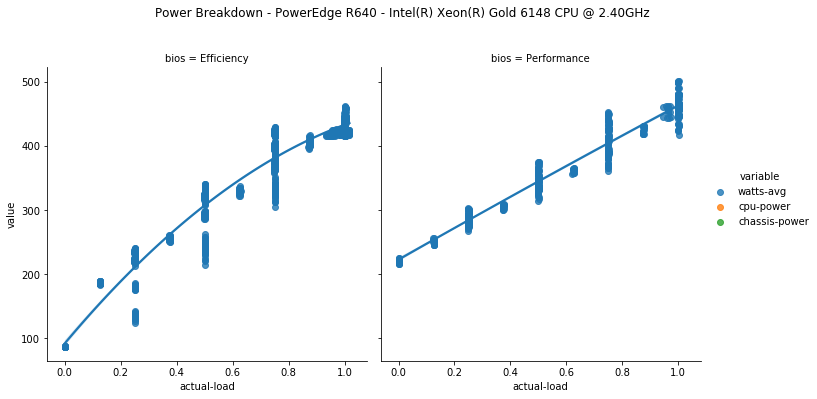

In [22]:
for server in cpu_worklets['scenario'].unique():
    plotdf = cpu_worklets[cpu_worklets['scenario'] == server].melt(['actual-load', 'bios'], ['watts-avg', 'cpu-power', 'chassis-power'])

    sns.lmplot(x='actual-load', y='value', col='bios', hue='variable', data=plotdf, order=2).fig.suptitle(f'Power Breakdown - {server}', y=1.1)

# CPU Utilisation vs SERT load level (per worklet)

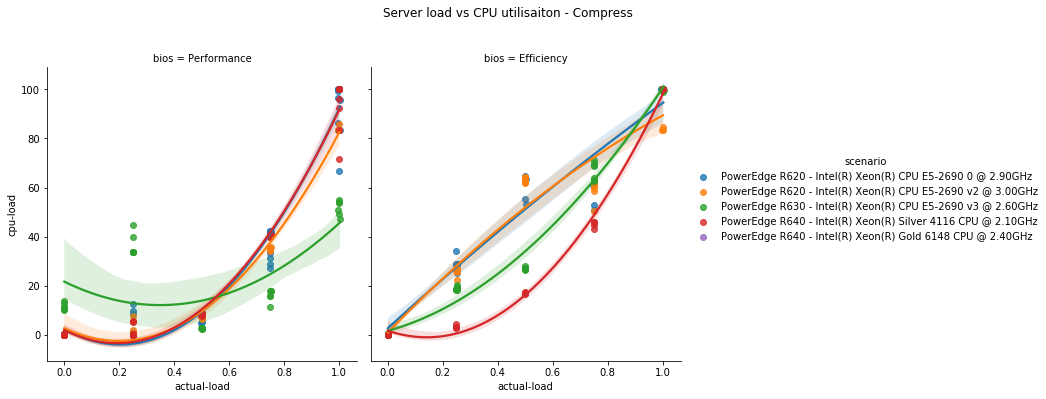

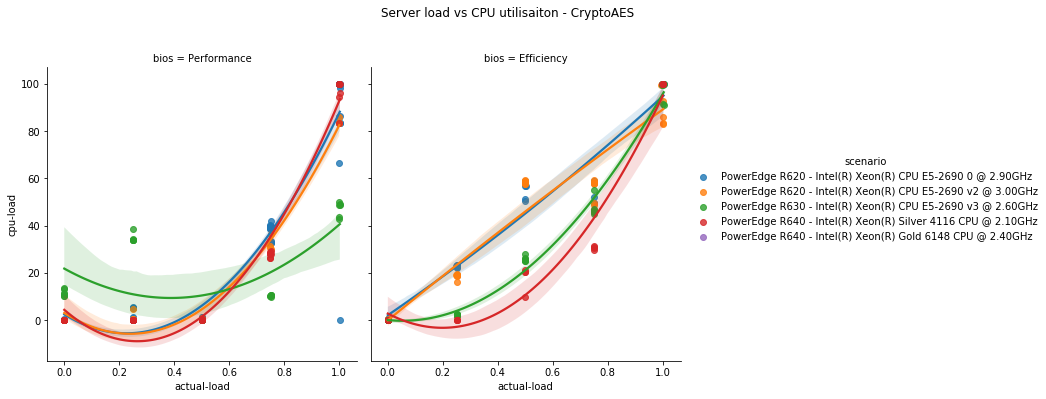

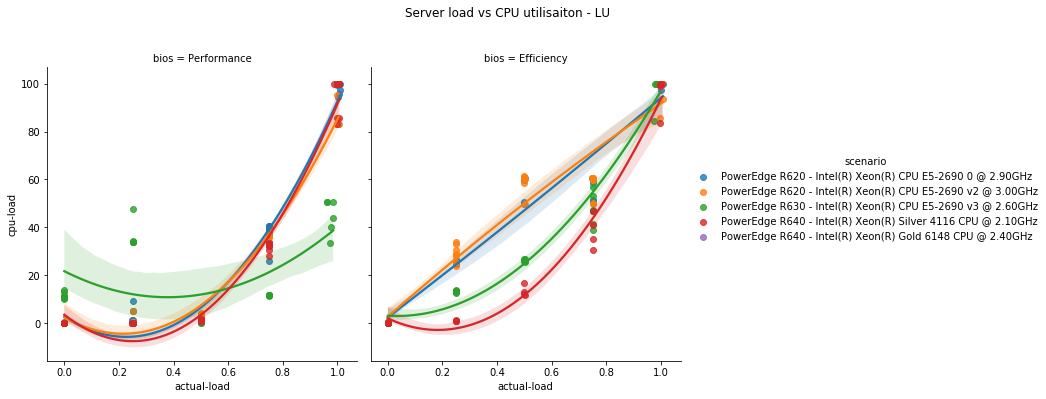

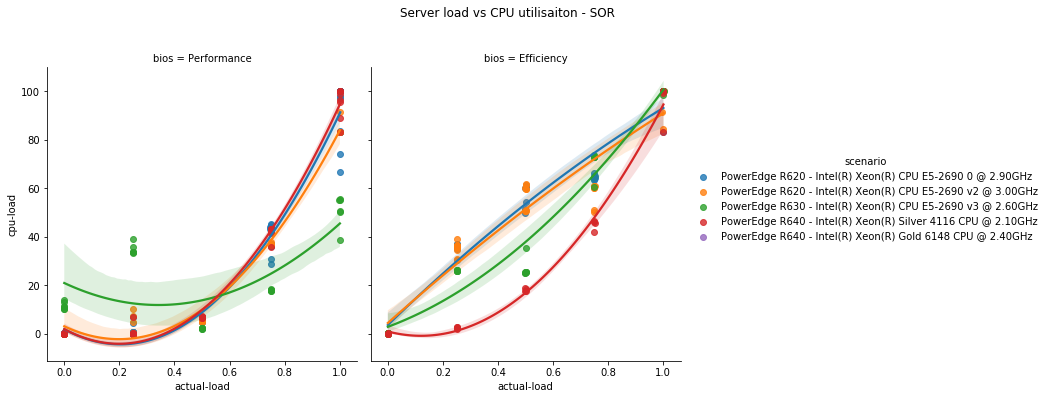

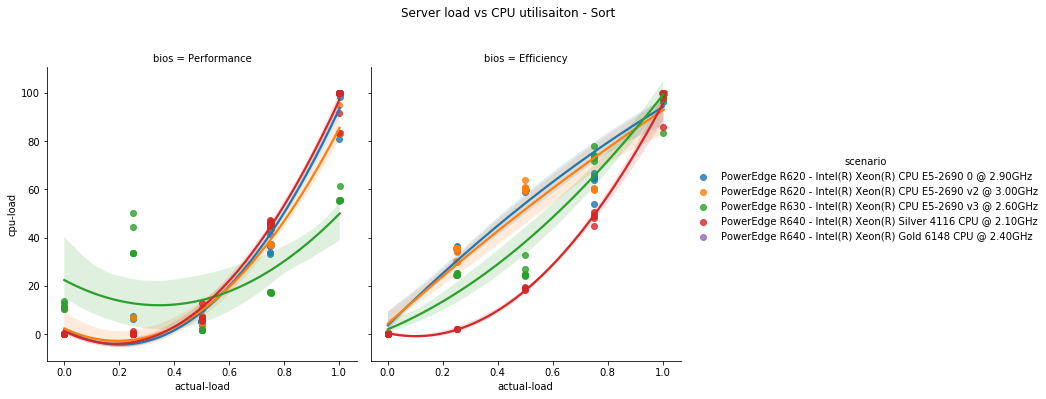

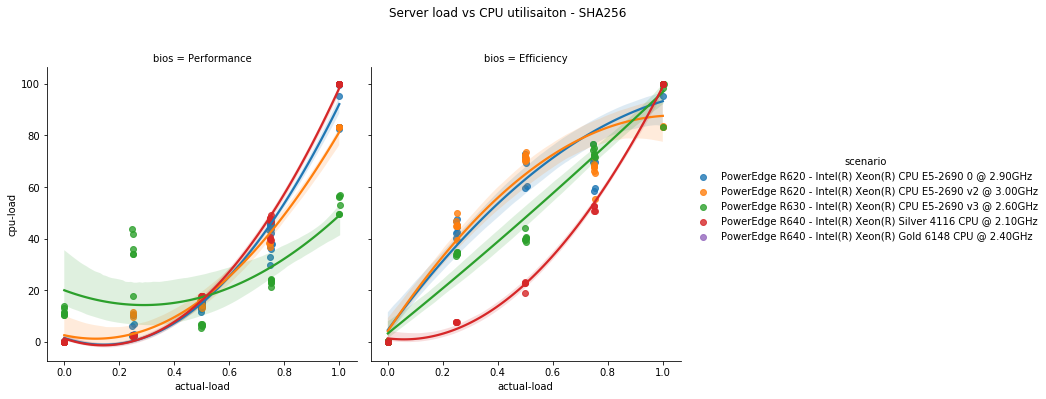

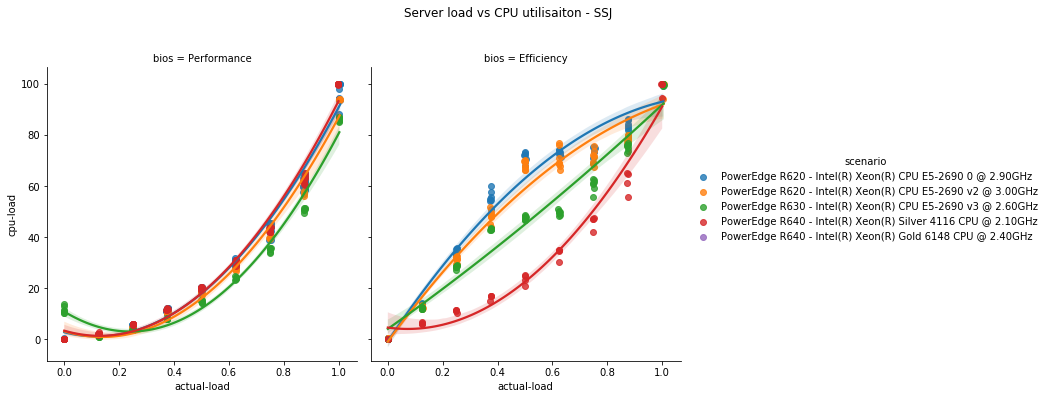

In [23]:
for worklet in sert_data[sert_data['workload'] == 'CPU']['worklet'].unique():
    sns.lmplot(data=sert_data[(sert_data['worklet'] == worklet) | (sert_data['workload'] == 'Idle')], x='actual-load', y='cpu-load', hue='scenario', col='bios', order=2).fig.suptitle(f'Server load vs CPU utilisaiton - {worklet}', y=1.1)

# Relationship between CPU temperature and average power

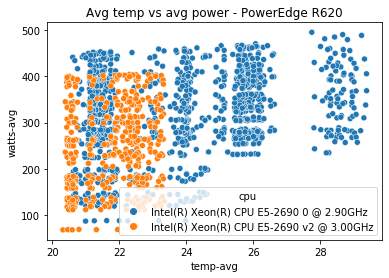

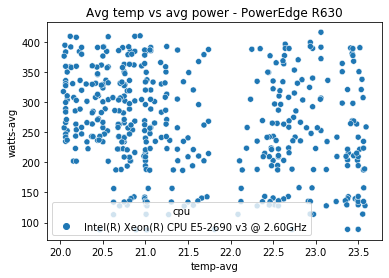

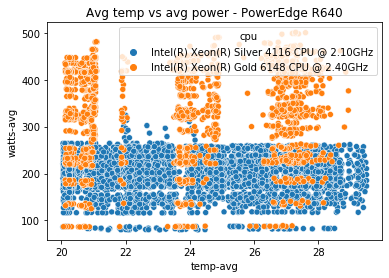

In [24]:
cpu = sert_data[(sert_data['workload'] == 'CPU')| (sert_data['workload'] == 'Idle')]
models=['PowerEdge R620', 'PowerEdge R630','PowerEdge R640']
for model in models:
    cpu_m = cpu[cpu['model'] == model]
    plt.figure()
    sns.scatterplot(x='temp-avg', y='watts-avg', hue='cpu', data=cpu_m)
    plt.gca().set_title(f'Avg temp vs avg power - {model}')

# Relationship between ambient temp. and CPU temp and power 

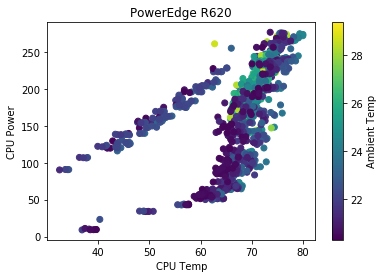

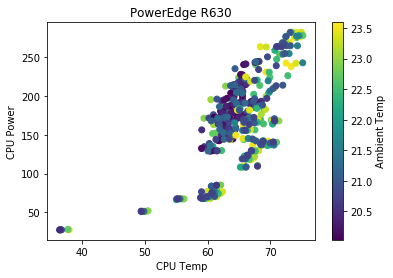

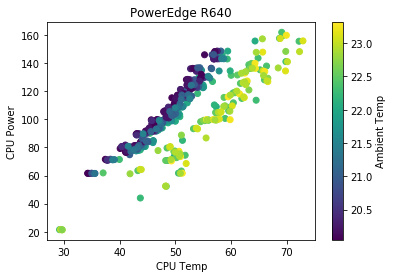

In [25]:
for model in models:
    cpu_m = cpu[cpu['model'] == model]
    plt.figure()
    ax = plt.scatter(x=cpu_m['cpu-temp'], y=cpu_m['cpu-power'], c=cpu_m['temp-avg'])
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Ambient Temp', rotation=90)
    plt.ylabel('CPU Power')
    plt.xlabel('CPU Temp')
    plt.title(f'{model}')

# Relationship between CPU load and CPU temperature and power

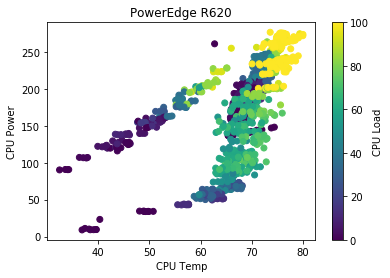

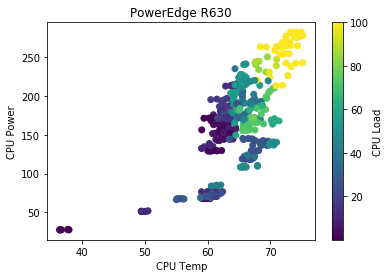

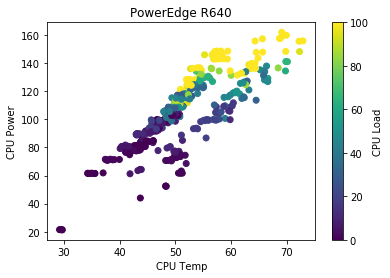

In [26]:
for model in models:
    cpu_m = cpu[cpu['model'] == model]
    plt.figure()
    ax = plt.scatter(x=cpu_m['cpu-temp'], y=cpu_m['cpu-power'], c=cpu_m['cpu-load'])
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('CPU Load', rotation=90)
    plt.ylabel('CPU Power')
    plt.xlabel('CPU Temp')
    plt.title(f'{model}')

# Relationship between cpu load and cpu frequency and power

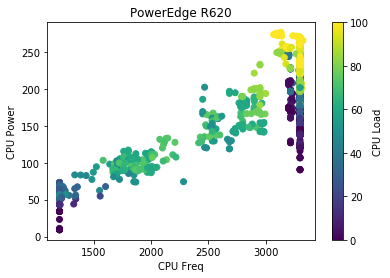

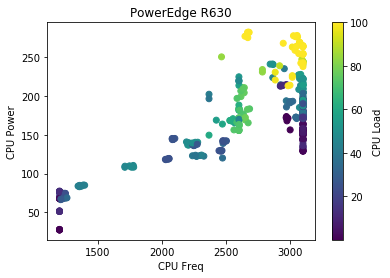

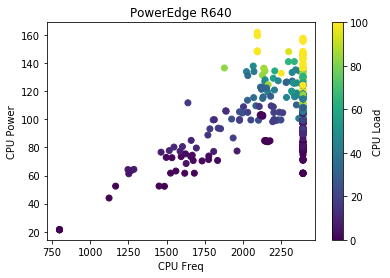

In [27]:
for model in models:
    cpu_m = cpu[cpu['model'] == model]
    plt.figure()
    ax = plt.scatter(x=cpu_m['cpu-freq'], y=cpu_m['cpu-power'], c=cpu_m['cpu-load'])
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('CPU Load', rotation=90)
    plt.ylabel('CPU Power')
    plt.xlabel('CPU Freq')
    plt.title(f'{model}')